In [1]:
import pandas as pd
pd.options.display.max_columns = 200

from crimes.coordinator import Coordinator

c = Coordinator()

---

In [2]:
df_crimes = c.data_interim.join('crimes.pkl').load()

In [3]:
df_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location X,Location Y,month,day,hour
0,10837815,JA140094,2017-02-02 17:00:00,021XX W WASHINGTON BLVD,820,THEFT,$500 AND UNDER,OTHER,False,False,1223,12,2,28,6,1162176.0,1900666.0,2017,2017-02-14 15:49:42,41.883092,-87.679939,41.883092,-87.679939,2,2,17
1,10837816,JA140085,2017-02-03 09:00:00,004XX N CICERO AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,1532,15,28,25,14,1144294.0,1902377.0,2017,2017-02-14 15:49:42,41.888142,-87.745560,41.888142,-87.745560,2,3,9
2,10837818,JA140112,2017-02-03 10:36:00,053XX W CHICAGO AVE,1330,CRIMINAL TRESPASS,TO LAND,GAS STATION,True,False,1524,15,37,25,26,1140422.0,1904813.0,2017,2017-02-14 15:49:42,41.894899,-87.759720,41.894899,-87.759720,2,3,10
3,10837819,JA140018,2017-02-03 09:22:00,014XX W 47TH ST,860,THEFT,RETAIL THEFT,CONVENIENCE STORE,False,False,924,9,3,61,6,1167554.0,1873583.0,2017,2017-02-14 15:49:42,41.808660,-87.660970,41.808660,-87.660970,2,3,9
4,10837821,JA140083,2017-02-02 23:00:00,056XX S MASSASOIT AVE,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE-GARAGE,False,False,811,8,23,56,5,1139004.0,1866529.0,2017,2017-02-14 15:49:42,41.789867,-87.765857,41.789867,-87.765857,2,2,23


In [4]:
beats = df_crimes.Beat.unique()
wards = df_crimes.Ward.unique()
areas = df_crimes['Community Area'].unique()
districts = df_crimes.District.unique()

In [5]:
len(beats), len(wards), len(areas), len(districts)

(274, 50, 77, 23)

---

In [6]:
df_wards_activity = df_crimes.groupby('Ward')\
    .agg({'Arrest': 'count'})\
    .reset_index()\
    .sort_values(by='Arrest', ascending=False)\
    .reset_index(drop=True)
df_wards_activity.Ward = df_wards_activity.Ward.astype(int).astype(str)

In [7]:
df_beats_activity = df_crimes.groupby('Beat')\
    .agg({'Arrest': 'count'})\
    .reset_index()\
    .sort_values(by='Arrest', ascending=False)\
    .reset_index(drop=True)
df_beats_activity.Beat = df_beats_activity.Beat.astype(int).astype(str)

In [8]:
df_dsts_activity = df_crimes.groupby('District')\
    .agg({'Arrest': 'count'})\
    .reset_index()\
    .sort_values(by='Arrest', ascending=False)\
    .reset_index(drop=True)
df_dsts_activity.District = df_dsts_activity.District.astype(int).astype(str)

---

In [9]:
c.data_external.contents()

['/opt/jupyterhub/notebooks/aolferuk/surf_demo/crimes/data/external/beats.json',
 '/opt/jupyterhub/notebooks/aolferuk/surf_demo/crimes/data/external/districts.json',
 '/opt/jupyterhub/notebooks/aolferuk/surf_demo/crimes/data/external/wards.json']

In [10]:
js_beats = c.data_external.join('beats.json').load()
js_dsts = c.data_external.join('districts.json').load()
js_wards = c.data_external.join('wards.json').load()

In [11]:
def extract_points(js, key):
    points = {}
    for j in js:
        name = j[key]
        crds = j['the_geom']['coordinates']
        points[name] = crds
    return points

In [12]:
points_wards = extract_points(js_wards, key='ward')
points_beats = extract_points(js_beats, key='beat_num')
points_dsts = extract_points(js_dsts, key='dist_num')

----

In [13]:
import contextily as ctx

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
df_wards_activity['area'] = 0

for i, wn in enumerate(df_wards_activity.Ward):
    df_wards_activity.loc[i, 'area'] = Polygon(points_wards[wn][0][0])

In [15]:
df_wards_activity['hue'] = df_wards_activity.Arrest / df_wards_activity.Arrest.max()

In [16]:
gdf = geopandas.GeoDataFrame(df_wards_activity, geometry='area')

In [17]:
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

In [26]:
def add_basemap(ax, zoom):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))

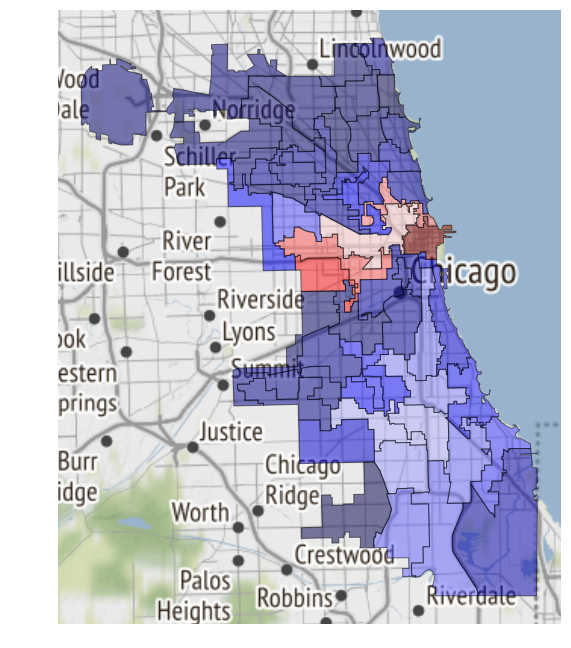

In [27]:
ax = gdf.plot(figsize=(9, 12), alpha=0.5, edgecolor='k', column='hue', cmap='seismic')
add_basemap(ax, zoom=10)
plt.gca().axis('off');